In [1]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

Node 36b6a277-86a1-4fde-a73f-2ed95257a43d

100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 333.30it/s]


fin state


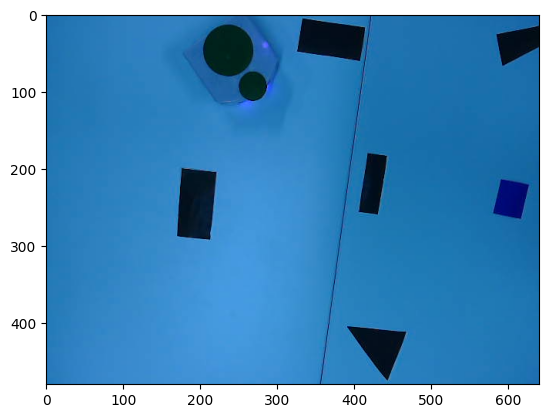

In [4]:
# Premade libraries
import cv2
import time
import math
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, Point, LineString

# Homemade functions
import Vision.vision as vs
import robot as rbt
import Global_Navigation.global_navigation as glb
import Motion_Control.thymio_control as ctrl

cap = cv2.VideoCapture(1)
img = vs.get_image(cap)
margin = 40
obstSpeedGain = np.array([6,4,-2,-6,-8])
thymio = rbt.RobotNav()

i = 0 #step vis graph
path = 0
while cap.isOpened():
    ret, frame = cap.read()
    
    if thymio.get_state() == 0:
        thymio.initialisation_step(frame, margin, False)
        thymio.set_state(1)
        path = thymio.get_path('real')
        print("fin state")
    
    if thymio.get_state() == 1:  #motion control commence
        pos_thy, two_centres, test_detect = vs.detect_start1(frame, False)  #recupere pos thymio, #test_detect bool a false si thymio pas detetc
        frame = glb.draw_path(frame, thymio.get_path('real')) #dessine chemin du thymio new fenetre
        path_img = thymio.get_path('img')
        if test_detect:
            frame = glb.draw_thymio(frame, path_img, "")   # dessine point thymio new fenetre
        #frame = glb.draw_thymio(frame, path_kalman)   # dessine point thymio new fenetre
        if test_detect:
            thymio.update_position_cam(two_centres, node, client)  #update pos thymio et angle dans la classe robot
        #else:
            #thymio.update_position_kalman(node, client, False)
    
        if len(path) > (i+1):
            next_goal = (path[i+1].x,path[i+1].y) 
            pos, teta = thymio.get_geometry()
             # astolfi implemetation
            temp=ctrl.astolfi(pos, teta, next_goal, node, client)
            if temp==1:
                i=i+1
            # jank implementation that works
        else : 
            ctrl.stop_motors(node)
            break
            '''
            angle = get_angle2goal(thymio.get_geometry(), next_goal)  #angle entre thymio et point
            get_correct_orientation(angle, node, 50, 0.2)
            if get_correct_orientation(angle, node, 50, 0.2):
                print("avance")
                get_distance(thymio.get_geometry()[0], next_goal, 30, 200, node)
                if get_distance(thymio.get_geometry()[0], next_goal, 30, 200, node):
                    i = i + 1
                    if i == (len(path)-1):
                        thymio.set_state(2)
                        ctrl.stop_motors(node)
                        print("arrivee")
                        print(thymio.get_state())
                        break      
        '''
    cv2.imshow('frame',frame)     
    if cv2.waitKey(1) == ord('q'):
        ctrl.stop_motors(node)
        break
        
cap.release()
cv2.destroyAllWindows()

In [ ]:
'''controller constants to tune accordingly'''
kp = 0.5  # >0
ka = 25  # > kp
kb = -0.01  # <0

'''speed limits and sensors thresholds to tune accordingly'''
v_max = 200
v_min = 20
thres_arrived = 50
angle_thres = 0.17
obstSpeedGain = np.array([6,4,-2,-6,-8])/100

'''Controller function'''
def astolfi(pos, theta, target, node, client):
    state = 0  # this functions is called recursivly untill state=1 i.e. the thymio has arrived
    delta_pos = [target[0] - pos[0], -(target[1] - pos[1])]
    rho = np.linalg.norm(delta_pos)
    alpha = -theta - np.arctan2(delta_pos[1], delta_pos[0])
    if alpha>np.pi:
        alpha-=2*np.pi
    elif alpha<-np.pi:
        alpha+=2*np.pi
    beta = theta - alpha
    if beta>np.pi:
        beta-=2*np.pi
    elif beta<-np.pi:
        beta+=2*np.pi
    sensors= np.array(get_prox_sensors(node, client)[0:5])
    vit_obst_left=np.sum(np.multiply(sensors,obstSpeedGain))
    vit_obst_right=np.sum(np.multiply(sensors,np.flip(obstSpeedGain)))
    #print("teta=",theta,"  alpa=",alpha,"  beta=",beta,"  rho=",rho) #prints to debug
    
    if (alpha>angle_thres):
        omega = ka * alpha + kb * beta
    else: 
        omega=kb*beta
    
    omega = ka * alpha + kb * beta
    if rho > thres_arrived:
        v = kp * rho
        if v > v_max: v = v_max
        if v < v_min: v = v_min
    else:
        v = 0
        state = 1
    left_speed = v - omega + vit_obst_left
    right_speed = v + omega + vit_obst_right
    set_motor_speed(int(right_speed), int(left_speed), node)
    return state